In [30]:
import json, os, torch, cv2, numpy as np, albumentations as A
from PIL import Image; from matplotlib import pyplot as plt
from glob import glob
from torch.utils.data import random_split, Dataset, DataLoader
from albumentations.pytorch import ToTensorV2

class CustomSegmentationDataset(Dataset):
    
    def __init__(self, root, transformations = None):

        self.im_paths = sorted(glob(f"{root}/*.jpg"))
        # self.im_paths = sorted(glob(f"{root}/images/*.png"))
        self.transformations = transformations
        
    def __len__(self): return len(self.im_paths)

    def __getitem__(self, idx):
        
        im = self.read_im(self.im_paths[idx])
        
        if self.transformations: im = self.apply_transformations(im)
        
        return im

    def read_im(self, path): return cv2.cvtColor(cv2.imread(path, cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB)

    def apply_transformations(self, im): transformed = self.transformations(image = im); return transformed["image"]

root = "../data/tef"
# root = "../data/human-in-the-loop"
mean, std, im_h, im_w = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225], 224, 224
trans = A.Compose( [A.Resize(im_h, im_w), A.augmentations.transforms.Normalize(mean = mean, std = std), ToTensorV2() ])
ds = CustomSegmentationDataset(root = root, transformations = trans)
test_dl = DataLoader(dataset = ds, batch_size = 1, shuffle = False, num_workers = 8, drop_last = True)

[5, 4, 3, 2]


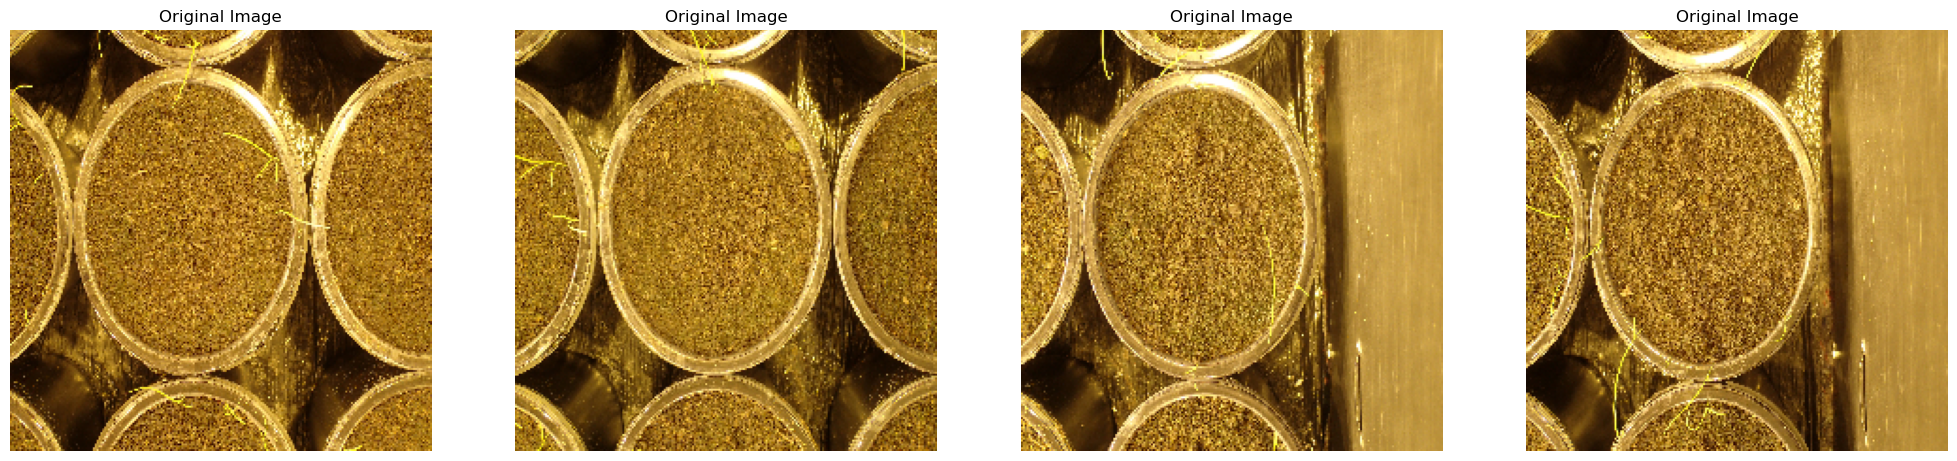

In [31]:
import random
from torchvision import transforms as tfs

def tn_2_np(t): 
    invTrans = tfs.Compose([ tfs.Normalize(mean = [ 0., 0., 0. ], std = [ 1/0.229, 1/0.224, 1/0.225 ]),
                                tfs.Normalize(mean = [ -0.485, -0.456, -0.406 ], std = [ 1., 1., 1. ]) ])
    
    rgb = True if len(t) == 3 else False
    
    return (invTrans(t) * 255).detach().cpu().permute(1,2,0).numpy().astype(np.uint8) if rgb else (t*255).detach().cpu().numpy().astype(np.uint8)

def plot(rows, cols, count, im, gt = None, title = "Original Image"):
    
    plt.subplot(rows, cols, count)
    plt.imshow(tn_2_np(im.squeeze(0).float())) if gt else plt.imshow(tn_2_np(im.squeeze(0)))
    plt.axis("off"); plt.title(title)
    
    return count + 1

def visualize(ds, n_ims):
    
    plt.figure(figsize = (25, 20))
    rows = n_ims // 4; cols = n_ims // rows
    count = 1
    indices = [random.randint(0, len(ds) - 1) for _ in range(n_ims)]
    print(indices)
    
    for idx, index in enumerate(indices):
        
        if count == n_ims + 1: break
        im = ds[index]
        
        # First Plot
        count = plot(rows, cols, count, im = im)
        
visualize(test_dl.dataset, n_ims = 4)

[5, 1, 3, 5, 3, 1, 1, 3, 3, 5]


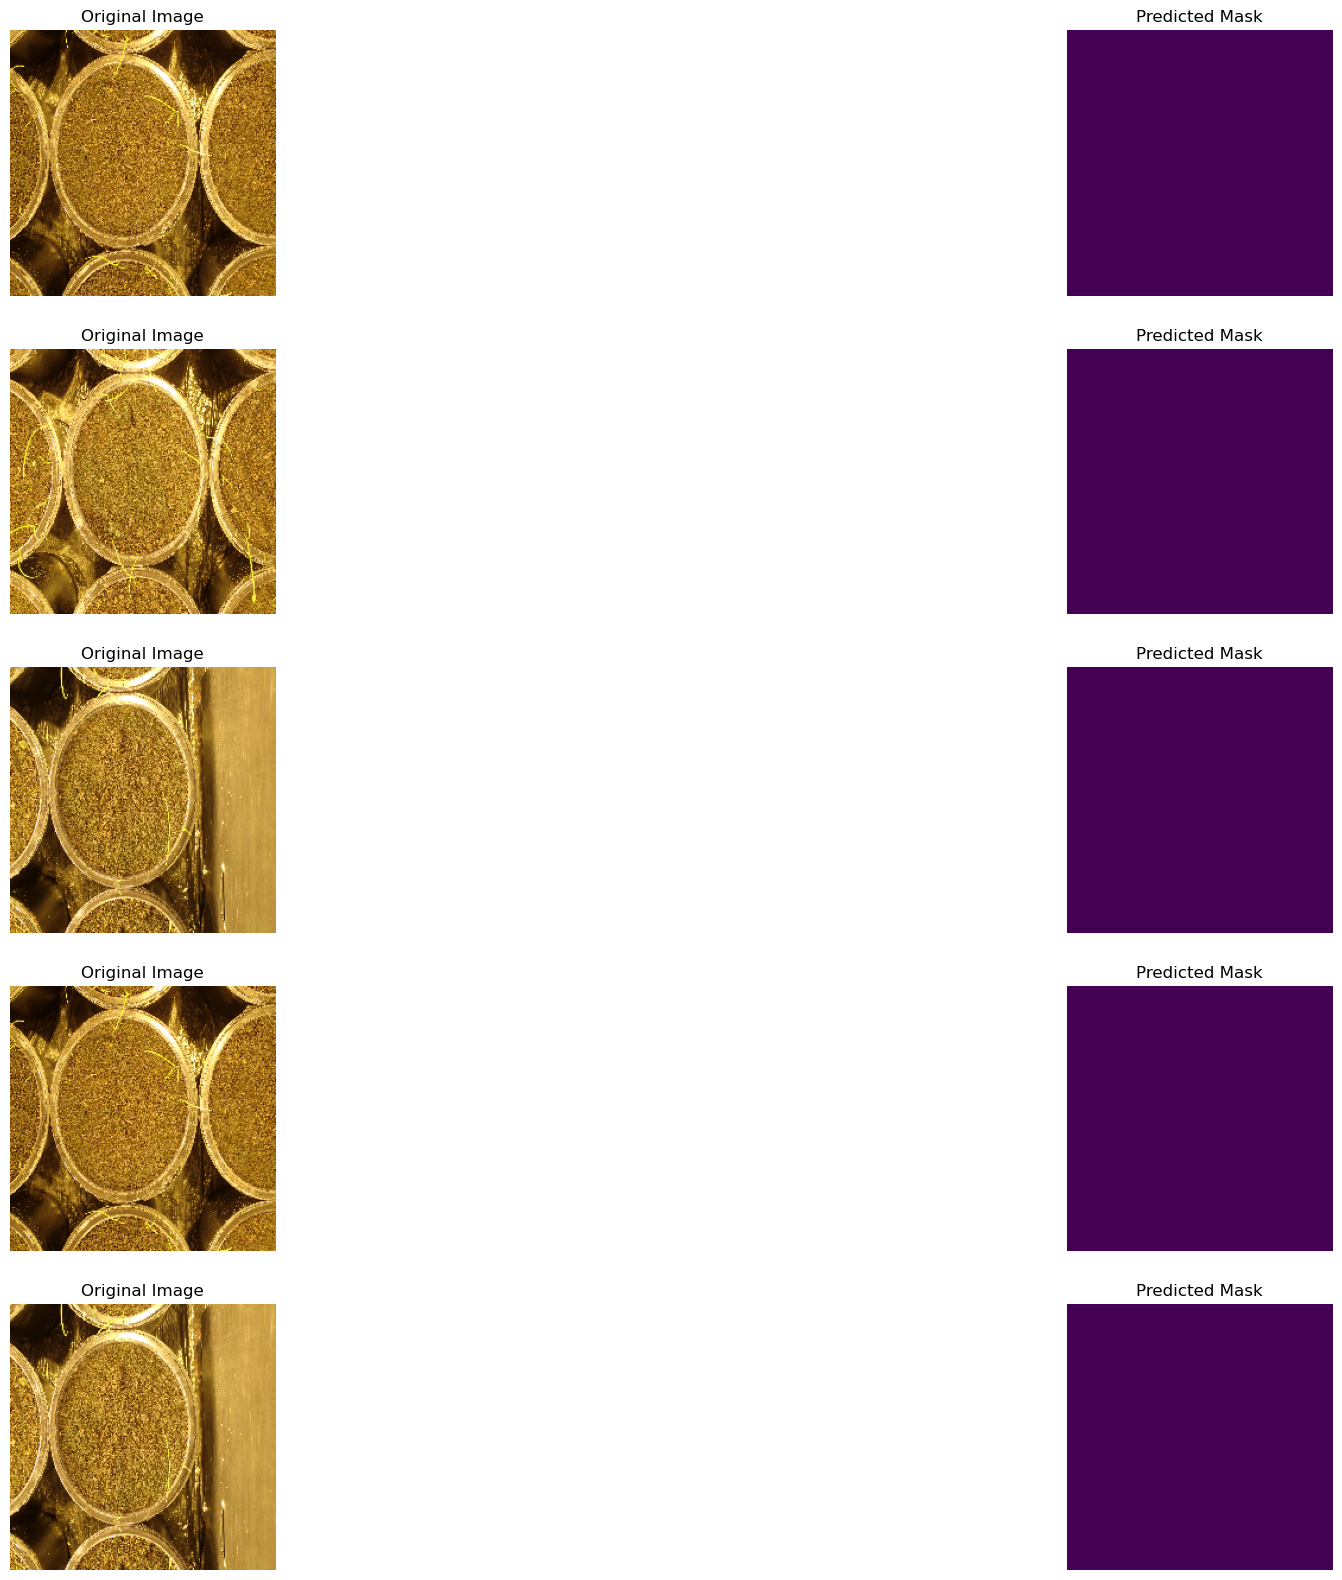

In [32]:
def inference(dl, model, device, n_ims = 15):
    
    cols = n_ims // 2; rows = n_ims // cols
    
    count = 1
    ims, preds = [], []

    rand_indices = [random.randint(0, len(dl.dataset) - 1) for _ in range(n_ims)]
    print(rand_indices)
    for rand_index in rand_indices:
        im = dl.dataset[rand_index].unsqueeze(0)

        # Get predicted mask
        with torch.no_grad(): pred = torch.argmax(model(im.to(device)), dim = 1)
        ims.append(im); preds.append(pred)
        
    plt.figure(figsize = (25, 20))
    for idx, (im, pred) in enumerate(zip(ims, preds)):
        if idx == cols: break
        
        # First plot
        count = plot(cols, rows, count, im)

        # Third plot
        count = plot(cols, rows, count, im = pred, title = "Predicted Mask")

model = torch.load("../saved_models/plant_best_model.pt") 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
inference(test_dl, model = model, device = device, n_ims = 10)